In [1]:
import sqlite3, pandas as pd
conn = sqlite3.connect("weather.db")
df_counts = pd.read_sql("""
    SELECT dl.city_name, COUNT(*) AS num_records
    FROM fact_weather AS fw
    JOIN dim_location AS dl
      ON fw.location_id = dl.location_id
    GROUP BY dl.city_name
""", conn)
conn.close()
print(df_counts)


   city_name  num_records
0  Bengaluru           50
1     London           50
2   New York           50


In [2]:
# ───────────────────────────────────────────────────────────────────────────────
# Back‐date Helper: Insert 24 hourly snapshots per city
# (run this in a Notebook cell, e.g. in App.ipynb or a new cell below your ETL)
# ───────────────────────────────────────────────────────────────────────────────
import pandas as pd
import requests
import time
import sqlite3
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os

# 1) Load API key
load_dotenv()
API_KEY = os.getenv("OWM_API_KEY")

# 2) Function to fetch one “current” record per city
OWM_URL = "https://api.openweathermap.org/data/2.5/weather"

def fetch_one_record(lat, lon, location_id):
    """
    Calls /data/2.5/weather once and returns a flattened dict with UNIX ts.
    """
    params = {
        "lat": lat,
        "lon": lon,
        "units": "metric",
        "appid": API_KEY
    }
    r = requests.get(OWM_URL, params=params, timeout=10)
    r.raise_for_status()
    data = r.json()
    return {
        "location_id":     location_id,
        "obs_ts":          data["dt"],           # UNIX timestamp
        "temp_c":          data["main"]["temp"],
        "feels_like_c":    data["main"]["feels_like"],
        "humidity_pct":    data["main"]["humidity"],
        "pressure_hpa":    data["main"]["pressure"],
        "wind_speed_ms":   data["wind"]["speed"],
        "clouds_pct":      data["clouds"]["all"],
        "weather_main":    data["weather"][0]["main"],
        "weather_desc":    data["weather"][0]["description"],
    }

# 3) Load all cities from dim_location
conn = sqlite3.connect("weather.db")
df_locs = pd.read_sql("SELECT location_id, lat, lon FROM dim_location", conn)

all_rows = []
for row in df_locs.itertuples(index=False):
    # Fetch the “base” current‐weather record for this city
    base = fetch_one_record(row.lat, row.lon, row.location_id)
    # Generate 24 snapshots: subtract 0..23 hours (in seconds)
    for h in range(24):
        snapshot = base.copy()
        snapshot["obs_ts"] = base["obs_ts"] - (h * 3600)
        all_rows.append(snapshot)
    # To respect rate limits, you might want a short sleep
    time.sleep(1)

conn.close()

# 4) Convert the list of dicts to a DataFrame
df_insert = pd.DataFrame(all_rows)

# Convert the back‐dated UNIX timestamp to UTC datetime
df_insert["obs_ts"] = pd.to_datetime(df_insert["obs_ts"], unit="s", utc=True)

# Select only the columns we need, in the correct order
df_to_write = df_insert[[
    "location_id", "obs_ts", "temp_c", "feels_like_c",
    "humidity_pct", "pressure_hpa", "wind_speed_ms",
    "weather_main", "weather_desc", "clouds_pct"
]]

# 5) Insert all rows at once into fact_weather
conn = sqlite3.connect("weather.db")
df_to_write.to_sql("fact_weather", conn, if_exists="append", index=False)
conn.close()

print(f"✅ Inserted {len(df_to_write)} rows into fact_weather (24 per city).")


✅ Inserted 72 rows into fact_weather (24 per city).


In [3]:
import sqlite3, pandas as pd

conn = sqlite3.connect("weather.db")
df_counts = pd.read_sql("""
    SELECT dl.city_name, COUNT(*) AS num_records
    FROM fact_weather AS fw
    JOIN dim_location AS dl 
      ON fw.location_id = dl.location_id
    GROUP BY dl.city_name
""", conn)
conn.close()
print(df_counts)


   city_name  num_records
0  Bengaluru           74
1     London           74
2   New York           74


Total rows for modeling: 222
Train rows: 177, Test rows: 45
Linear Regression MSE: 0.23
Linear Regression R²:  0.93

Learned Coefficients:
        feature  coefficient
0        temp_c    -5.828186
1  feels_like_c     4.508419


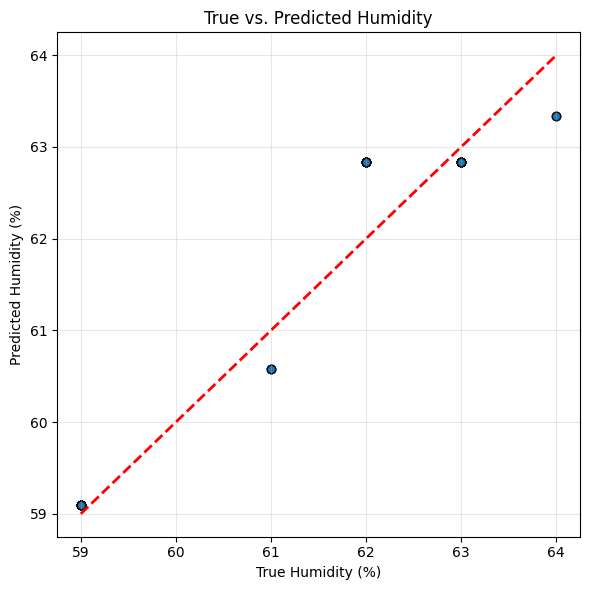

In [4]:
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1) Load the data (including city_name if you want to inspect)
conn = sqlite3.connect("weather.db")
df = pd.read_sql("""
    SELECT temp_c, feels_like_c, humidity_pct
    FROM fact_weather
""", conn)
conn.close()

# 2) Drop missing values
df = df.dropna(subset=['temp_c', 'feels_like_c', 'humidity_pct'])

print(f"Total rows for modeling: {len(df)}")  # should be ~72 now

# 3) Define features and target
X = df[['temp_c', 'feels_like_c']]
y = df['humidity_pct']

# 4) Train/test split (20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train rows: {len(X_train)}, Test rows: {len(X_test)}")

# 5) Train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# 6) Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"Linear Regression MSE: {mse:.2f}")
print(f"Linear Regression R²:  {r2:.2f}")

# 7) Coefficients
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_
})
print("\nLearned Coefficients:")
print(coef_df)

# 8) Optional: Plot True vs. Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)
plt.title("True vs. Predicted Humidity")
plt.xlabel("True Humidity (%)")
plt.ylabel("Predicted Humidity (%)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
